# The Bias-Variance Tradeoff

In the previous subsection we have seen that the regression objective of minimizing the RSS has some reallly nice properties: we can determine the global optimum in an analytic way (by means of a formula). However, the initial goal of regression was to find the true feature-target relationship from the data. We want to find the _true_ regression function. The question is now how we can evaluate our regression model towards our goal, when we don't know what the true regression function is.

Let us take a step back and create an example where we do know the true regression function. To do so, we generate  a synthetic dataset from the function $f^*(x) = \cos(1.5\pi x)$ (which we define as our true regression function) and some noise. We plot first our true regression function:

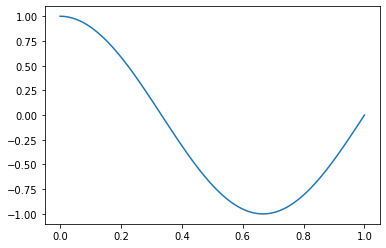

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def f_true(x):
    return np.cos(1.5 * np.pi * x)
x = np.linspace(0,1,100)
plt.plot(x,f_true(x))
plt.show()

To create the synthetic dataset, we sample some data points from the interval $[0,1]$ and add some noise on the target values $y= f^*(x)+\epsilon$. We sample the noise from a Gaussian normal distribution $\epsilon\sim\mathcal{N}(0,\sigma)$.  

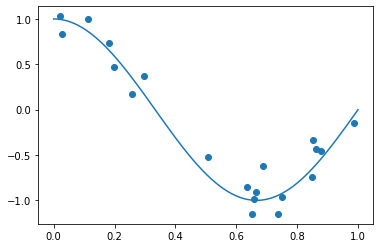

In [6]:
np.random.seed(18) # set the seed of the random generator for reproducibility
n=20 # the number of data points
sigma = 0.15
D = np.random.uniform(0,1,n) # sample n data points from a uniform distribution
y = f_true(D) + np.random.normal(0,sigma,n)
x = np.linspace(0,1,100)
plt.plot(x,f_true(x))
plt.scatter(D,y) #plot the data points
plt.show()

Now we have a synthetic dataset, given by the data matrix `D` and target vector `y`. We fit to this dataset  polynomial functions of varying degrees $k\in\{1,4,16\}$:

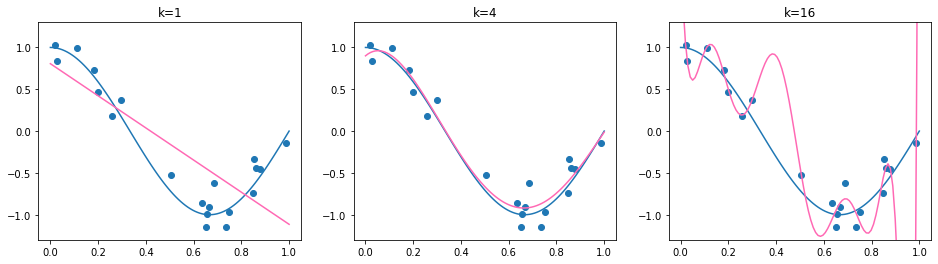

In [7]:
from sklearn.preprocessing import PolynomialFeatures
plt.figure(figsize=(16, 4))
p = 1
for k in [1,4,16]:
    plt.subplot(1, 3 , p)
    poly = PolynomialFeatures(k)
    X = poly.fit_transform(D.reshape(-1, 1)) #design matrix for polynomal of degree k
    β = np.linalg.solve(X.T@X+1e-20*np.eye(X.shape[1]), X.T@y)
    plt.scatter(D,y, marker='o')
    plt.plot(x,f_true(x))
    plt.plot(x,poly.fit_transform(x.reshape(-1, 1))@β, color='hotpink')
    plt.ylim(-1.3,1.3)
    plt.title('k='+str(k))
    p+=1

We can see that the found regression function is quite sensitive to the degree of the polynomial. Choosing $k=1$ results in a too simple model, choosing $k=4$ results in a regression function which is close to the true regression function and choosing $k=14$ adapts very well to the data, but the difference to $f^*$ is quite big, especcially in those areas where we have only few observations ($x\geq 0.6$). But how can we determine the correct degree $k$ in practice, when we can't compare with the true regression function?

## Evaluation with a Test Set: the Practice
Since we don't know the true regression function in practical applications, we resort to test the models ability to generalize.
The idea is that a model which is close to the true regression function, should be able to predict $y$ for _unobserved_ $\mathbf{x}$.

**Idea**: Hold out a test set, indicated by $\mathcal{T}\subseteq\mathcal{D}$ from the $n$ training data points and compute the error on the test data.


The **Mean Squared Error (MSE)** returns the average squared prediction error:
$$ MSE(\bm{\beta}, \mathcal{T})= \frac{1}{\lvert \mathcal{T}\rvert}\sum_{(\vvec{x},y)\in\mathcal{T}}(y-\bm{\phi}(\vvec{x})^\top \bm{\beta})^2$$

In [8]:
from sklearn.model_selection import train_test_split
D_train, D_test, y_train, y_test = train_test_split(D, y, test_size=0.3, random_state=18) 
print(D_train.shape, D_test.shape)

(14,) (6,)


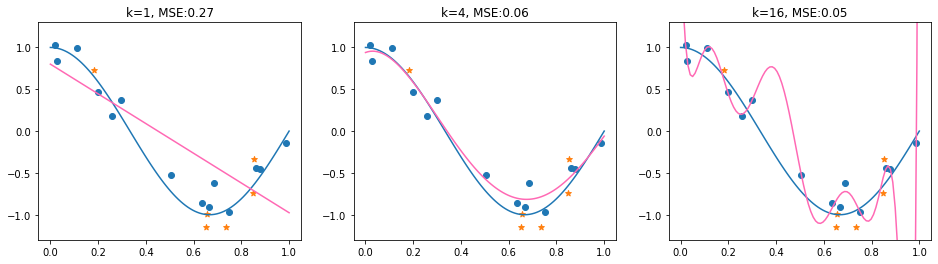

In [9]:
def mse(y_1,y_2):
    return np.mean((y_1-y_2)**2)
plt.figure(figsize=(16, 4))
p = 1
for k in [1,4,16]:
    plt.subplot(1, 3 , p)
    poly = PolynomialFeatures(k)
    X_train = poly.fit_transform(D_train.reshape(-1, 1)) #design matrix for polynomal of degree k
    X_test = poly.fit_transform(D_test.reshape(-1, 1))
    β = np.linalg.solve(X_train.T@X_train, X_train.T@y_train)
    plt.scatter(D_train,y_train, marker='o')
    plt.scatter(D_test,y_test, marker='*')
    plt.plot(x,f_true(x))
    plt.plot(x,poly.fit_transform(x.reshape(-1, 1))@β, color='hotpink')
    plt.ylim(-1.3,1.3)
    plt.title('k='+str(k)+', MSE:'+str(np.round(mse(X_test@β,y_test),2)))
    p+=1

The example shows a case where the test MSE fails to identify the suitable model choice ($k=4$). The model with $k=16$ obtains here the lowest MSE. Although this is not always the case (in fact, the MSE results are quite sensitive to the `random_state` of the train and test split), it may happen. The question is if there are maybe some theoretical insights into MSE, which help us estimate which components influence the test-MSE and how we can make the test-process more reliable.

## Evaluation with a Test Set: the Theory
In theory, the test-MSE results from the following process: 
1. sample the (finite) training data $\mathcal{D}_j\subset\mathbb{R}^{1\times d}\times \mathbb{R}$
2. learn a model $f_{\mathcal{D}_j}(\mathbf{x})=\bm{\phi}(\mathbf{x})^\top \bm{\beta}_j$ based on the training data,
3. sample a (finite) test set $\mathcal{T}_j\subset\mathbb{R}^{1\times d}\times \mathbb{R}$ 
4. compute $MSE_j$

If we repeat this sampling process $k$ times, obtaining scores $MSE_1,\ldots,MSE_k$, we could approximate the **Expected squared Prediction Error** (EPE). The expected squared prediction error returns the squared error of a model $f(x)$ and target $y$, where $f$ is derived from training data $\mathcal{D}$. 
```{prf:definition} EPE
The Expected squared Prediction Error (EPE) is the expected error 
$$\mathbb{E}_{\mathbf{x},y,\mathcal{D}}[(y-f_\mathcal{D}(\mathbf{x}))^2],$$
over three random variables:
* $\vvec{x}$ is the random variable of a feature vector in the test set.
* $y$ is the random variable of the target of $\vvec{x}$.
* $\mathcal{D}$ is the random variable of the training data.
```
We can approximate the EPE with our sample MSEs:
:::{math}
:label: eq:mse_approx
\frac1k\sum_{j=1}^k MSE_j=\frac1k\sum_{j=1}^k\frac{1}{\lvert\mathcal{T}_j\rvert}\sum_{(\mathbf{x},y)\in\mathcal{T}_j}(y-f_j(\mathbf{x}))^2\approx\mathbb{E}_{\mathbf{x},y,\mathcal{D}}[(y-f_\mathcal{D}(\mathbf{x}))^2].
:::

The EPE is a theoretical construct. In practice, we have only on dataset. For the approximation of EPE, we would need multiple independently drawn datasets. Still, it makes sense to analyze the EPE to identify the characteristics that define theoretically guaranteed well performing models. We consider then how we can anlayze said properties in the real world.        

### Regression Targets as Random Variables
The target values $y$ are not assumed to yield the true regression values per se. We can assume that the targets exhibit a natural amount of variance, reflecting random processes that influence the target. For example, target values such as the outside temperature fluctuate, even when it is measured every year at the same spot and the same time. Likewise, house prices are dependent on personal impressions on how much a house is worth, that can not reasonably be modeled in an observable feature space.  

````{prf:property} Target Value Distribution
:label: prop:target_distr
Given the _true_ regression function $f^*$ and observation $\mathbf{x}_i$, we assume that the target value is generated as 
$$ y_i = f^*(\mathbf{x}_i)+\epsilon_i,$$
where $\epsilon_i$ is an i.i.d. (independent and identically distributed) sample of a random variable $\epsilon$ with mean $\mu=0$ and variance $\sigma^2$.
As a result, the targets are samples of the random variable $y=f^*(\vvec{x})+\epsilon$ such that
\begin{align*}
    \mathbb{E}_y[y\vert \mathbf{x}] = f^*(\mathbf{x}) &&
    Var_y(y\vert \mathbf{x}) = \mathbb{E}_y[(y-f^*(\mathbf{x}))^2\vert \mathbf{x}] = \sigma^2
\end{align*}
````

We sample some training data with Gaussian noise, to observe the effect of $\sigma$.
The plot below indicates samples generated by the following procedure:
1. Sample $x_{i}\in[0,1]$ for $1\leq i \leq n$
2. Sample $\epsilon_i$ from $\mathcal{N}(0,\sigma^2)$
3. Set $y_i=f^*(x_{i})+\epsilon_i$


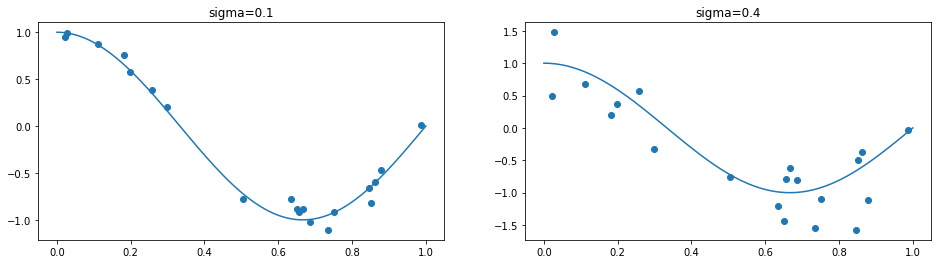

In [10]:
plt.figure(figsize=(16, 4))
p = 1
for sigma in [0.1,0.4]:
    plt.subplot(1, 2 , p)
    y = f_true(D) + np.random.normal(0,sigma,n)
    x = np.linspace(0,1,100)
    plt.plot(x,f_true(x))
    plt.scatter(D,y) #plot the data points
    plt.title('sigma='+str(sigma))
    p+=1

The plot on the left is generated with a low variance ($\sigma=0.1$) and the plot on the right is generated with a larger variance ($\sigma=0.4$). Correspondingly, the target values with a low variance are closer to the true regression function than those with a bigger variance. It seems as if the true regression function is more easy to observe from the data in the left plot. Does that mean that it's easier to approximate the true regression function if the variance is low? Surprisingly, that is not the case, as we will observe via the bias-variance trade-off.

## The Bias-Variance Tradeoff
The Bias-Variance Tradeoff describes the fit of a regression model to the true regression model by means of its bias and variance. 
$$ \mathbb{E}_{\mathbf{x},y,\mathcal{D}}[(y-f_\mathcal{D}(\mathbf{x}))^2]=\mathbb{E}_\mathbf{x}[\mathbb{E}_{y,\mathcal{D}}[(y-f_\mathcal{D}(\mathbf{x}))^2\vert \mathbf{x}]]$$
```{prf:theorem}
Assuming that {prf:ref}`prop:target_distr` holds, the EPE for any observation $\mathbf{x}_0$ can be deconstructed into three parts:
\begin{align*}
    \mathbb{E}_{y,\mathcal{D}}[(y-f_\mathcal{D}(\mathbf{x}_0))^2]  
    = \sigma^2 &+\underbrace{(f^*(\mathbf{x}_0)-\mathbb{E}_\mathcal{D}[f_\mathcal{D}(\mathbf{x}_0)])^2}_{bias^2}\\ &+\underbrace{\mathbb{E}_\mathcal{D}[(\mathbb{E}_\mathcal{D}[f_\mathcal{D}(\mathbf{x}_0)]-f_\mathcal{D}(\mathbf{x}_0))^2}_{variance}] 
\end{align*}
```
````{toggle}
```{prf:proof}
We add and subtract $f^*(x_0)$ in the squared error term of EPE, apply the binomial formula and the linearity of the expected value to get
:::{math}
:label: eq:bias_var1
\begin{align}
\mathbb{E}_{y,\mathcal{D}}&[(y-f_\mathcal{D}(\mathbf{x}))^2]\\
=&\mathbb{E}_{y,\mathcal{D}}[(y-f^*(x_0)+f^*(x_0)-f_\mathcal{D}(x_0))^2] \\
=&\mathbb{E}_{y,\mathcal{D}}[(y-f^*(x_0))^2+2(y-f^*(x_0))(f^*(x_0)-f_\mathcal{D}(x_0))+(f^*(x_0)-f_\mathcal{D}(x_0))^2]\\
=&\mathbb{E}_{y,\mathcal{D}}[(y-f^*(x_0))^2]
+2\mathbb{E}_{y,\mathcal{D}}[(y-f^*(x_0))(f^*(x_0)-f_\mathcal{D}(x_0))] 
+\mathbb{E}_{y,\mathcal{D}}[(f^*(x_0)-f_\mathcal{D}(x_0))^2]
\end{align}
:::
The term on the left is the variance of the target value:
\begin{align*}
\mathbb{E}_{y,\mathcal{D}}[(y-f^*(x_0))^2] = \mathbb{E}_{y}[(y-f^*(x_0))^2] = \sigma^2.
\end{align*}
The first equality holds here because the term in the expectation doesn't depend on $\mathcal{D}$, and the last equality follows from {prf:ref}`prop:target_distr`.
The second term is equal to zero, since the random variable $y$ is independently drawn, and hence we can apply the expected value on each product term, giving   
\begin{align*}
2\mathbb{E}_{y,\mathcal{D}}[(y-f^*(x_0))(f^*(x_0)-f_\mathcal{D}(x_0))] = 2\mathbb{E}_{y}[(y-f^*(x_0))]\mathbb{E}_{\mathcal{D}}[(f^*(x_0)-f_\mathcal{D}(x_0))] = 0.
\end{align*}
The product above is zero, since the expected value of $y$ is $f^*(x_0)$, and hence $\mathbb{E}_{y}[(y-f^*(x_0))]=0$. The rightmost term in Equation {eq}`eq:bias_var1` does only depend on the training data random variable now, and we expand it by adding and subtracting the expected value of the model output and applying again the binomial formula and the linearity of the expected value.
\begin{align*}
\mathbb{E}_{y,\mathcal{D}}&[(f^*(x_0)-f_\mathcal{D}(x_0))^2] \\
=& \mathbb{E}_{\mathcal{D}}[(f^*(x_0)-\mathbb{E}_{\mathcal{D}}[f_{\mathcal{D}}(x_0)]+\mathbb{E}_{\mathcal{D}}[f_{\mathcal{D}}(x_0)]-f_\mathcal{D}(x_0))^2]\\
=& \mathbb{E}_{\mathcal{D}}[(f^*(x_0)-\mathbb{E}_{\mathcal{D}}[f_{\mathcal{D}}(x_0)])^2] +2\mathbb{E}_{\mathcal{D}}[(f_{\mathcal{D}}(x_0)-\mathbb{E}_{\mathcal{D}}[f_{\mathcal{D}}(x_0)])(\mathbb{E}_{\mathcal{D}}[f_{\mathcal{D}}(x_0)]-f_\mathcal{D}(x_0))] + \mathbb{E}_{\mathcal{D}}[(\mathbb{E}_{\mathcal{D}}[f_{\mathcal{D}}(x_0)]-f_\mathcal{D}(x_0))^2]
\end{align*}
The term on the left is the squared bias, the outer expected value operator doesn't do anything, because the argument is not dependent on a random variable anymore, and can be omitted. The rightmost term is the variance of the model. The middle term is again zero, because the left product term is a constant and can be multiplied outside of the expected value operator, yielding
\begin{align*}
2\mathbb{E}_{\mathcal{D}}&[(f^*(x_0)-\mathbb{E}_{\mathcal{D}}[f_{\mathcal{D}}(x_0)])(\mathbb{E}_{\mathcal{D}}[f_{\mathcal{D}}(x_0)]-f_\mathcal{D}(x_0))]\\ 
=& 2(f^*(x_0)-\mathbb{E}_{\mathcal{D}}[f_{\mathcal{D}}(x_0)])\mathbb{E}_{\mathcal{D}}[(\mathbb{E}_{\mathcal{D}}[f_{\mathcal{D}}(x_0)]-f_\mathcal{D}(x_0))]\\
=& 2(f^*(x_0)-\mathbb{E}_{\mathcal{D}}[f_{\mathcal{D}}(x_0)])(\mathbb{E}_{\mathcal{D}}[f_{\mathcal{D}}(x_0)]- \mathbb{E}_{\mathcal{D}}[f_\mathcal{D}(x_0)])]\\
=&0.
\end{align*}
```
````
Hence, the expected squared prediction error is minimized for functions (models) having a _low variance_ and _low bias_. We illustrate the effect by our running example. The true regression function is again $f^*(x) = \cos(1.5\pi x)$ and the training set $\mathcal{D}_j$ is sampled i.i.d. from the interval $[0,3]$ for each model $f_{\mathcal{D}_j}$. We obtain five regression models for three polynomial function classes: affine functions (polynomials of degree $k=1$), polynomials of degree $k=4$ and polynomials of degree $k=16$. The obtained regression models $f_\mathcal{D}$ are plotted below. 


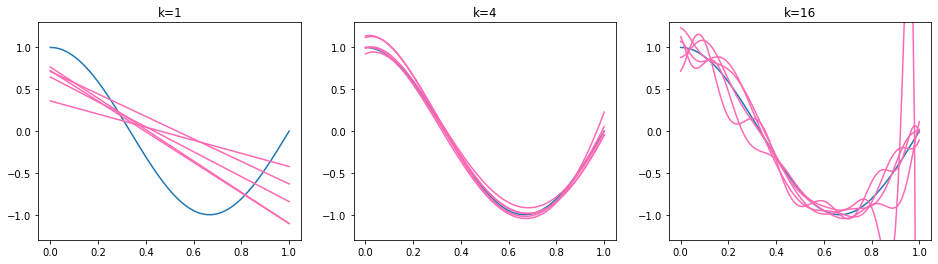

In [34]:
plt.figure(figsize=(16, 4))
p = 1
n=30
for k in [1,4,16]:
    plt.subplot(1, 3 , p)
    poly = PolynomialFeatures(k)
    plt.plot(x,f_true(x))
    for l in range(0,5):
        D = np.random.uniform(-0.1,1.1,n) # sample n data points from a uniform distribution
        y = f_true(D) + np.random.normal(0,0.15,n) # sample the target values
        X = poly.fit_transform(D.reshape(-1, 1)) #design matrix for polynomal of degree k
        β = np.linalg.solve(X.T@X, X.T@y)
        plt.plot(x,poly.fit_transform(x.reshape(-1, 1))@β, color='hotpink')
    plt.ylim(-1.3,1.3)
    plt.title('k='+str(k))
    p+=1

We observe that the functions on the left are too simple - affine functions can't model the curvature of the true regression function. The affine functions show a low variance, they all go roughly from the top left to the bottom right. The functions in the middle ($k=4$) are all similar (low variance) and fit well to the true regression function (low bias). The functions on the right ($k=16$) follow the shape of the true regression function (low bias) but some of the lines differ a lot from the others (high variance). The bias of the higher degree models is not easy to see here, so we provide an additional visualization below. We recall that the bias represents the distance of the mean function value $\mathbb{E}_\mathcal{D}[f_\mathcal{D}(\mathbf{x}_0)]$ and the true regression function. We illustrate the bias by plotting the mean of 500 regression models below in orange. Hence, the orange line approximates the mean function value $\mathbb{E}_\mathcal{D}[f_\mathcal{D}(\mathbf{x}_0)]$.

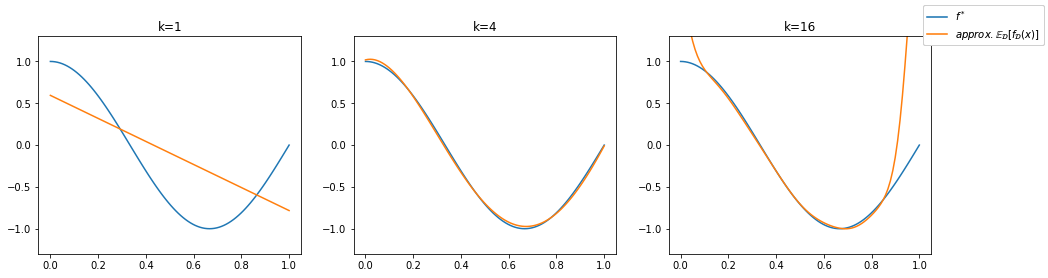

In [36]:
fig = plt.figure(figsize=(16, 4))
p = 1
for k in [1,4,16]:
    plt.subplot(1, 3 , p)
    poly = PolynomialFeatures(k)
    y_bias = np.zeros(x.shape[0])
    nr_models=500
    for l in range(0,nr_models):
        D = np.random.uniform(-0.1,1.1,n) # sample n data points from a uniform distribution
        y = f_true(D) + np.random.normal(0,0.15,n) # sample the target values
        X = poly.fit_transform(D.reshape(-1, 1)) #design matrix for polynomal of degree k
        β = np.linalg.solve(X.T@X, X.T@y) # learn the regression paarmeetr vector
        y_bias += poly.fit_transform(x.reshape(-1, 1))@β # aggregate over the regression function values
    plt.plot(x,f_true(x),label='$f^*$')
    plt.plot(x,y_bias/nr_models, color='tab:orange', label="$approx. \mathbb{E}_{\mathcal{D}}[f_{\mathcal{D}}(x)]$")
    plt.ylim(-1.3,1.3)
    plt.title('k='+str(k))
    line, label = fig.axes[0].get_legend_handles_labels()
    fig.legend(line,label)
    p+=1

We can see that the polynomials of a degree $k\geq 4$ approximate the true regression function well **in average**. This indicates a small bias. For $k=16$ we see stark differences to the true regression function at the ends of the interval $[-0.1,1.1]$ in which we sample our data points, but this effect will diminish if the number of trained models goes to infinity. Especially at the interval ends, data might be sparse and the model is unguided, resulting in graphs that diverge quickly from the data distribution. Only the underfitting model using $k=1$ is not able to reflect the true regression curve. We observe the approximated bias as the distance between the orange and the blue curve for each value on the horizontal axis.     

In summary, we have discussed that the EPE is composed of three parts: the variance in the data (that we can't influence), the squared bias (the squared distance of the expected model prediction to the true regression function) and the variance of the models. Those concepts are connected with the terms of under- and overfitting. An underfitting model has a high bias and a low variance, and an overfitting model has a high variance and a low bias. The models that we want are in the middle between under- and overfitting, achieving a low variance and bias.

## Cross-Validation
Now that we know what we expect in theory from a well-fitting model, we can think about applying this knowledge to practical model evaluations. A widely applied method that intends to mimick the evaluation process of generating multiple test-set MSEs to approximate the EPE is **cross validation**.

```{prf:algorithm} $k$-fold CV
1. Divide the data set into $k$ disjunctive chunks, containing the data point indices $$\{1,\ldots,n\}=\mathcal{I}=\mathcal{I}_1\cup\ldots \cup\mathcal{I}_k,\  \mathcal{I}_j\cap\mathcal{I}_l=\emptyset \text{ for } j\neq l$$
2. **For** $j\in\{1,\ldots,k\}$
    1. Obtain model $f_{j}(\mathbf{x})=\bm{\phi}(\mathbf{x})^\top \bm{\beta}_j$ on the training data $\mathcal{I}\setminus\mathcal{I}_j$
    2. Obtain the test-MSE $MSE_j$ on test set $\mathcal{I}_j$     
3. **Return** $\frac{1}{k}\sum_{j=1}^k MSE_j$
```

The k-fold cross validation computes the **cross-validation MSE**, given as
$$\frac1k\sum_{j=1}^k MSE(\bm{\beta}_j,\mathcal{I}_j)= \frac1k\sum_{j=1}^k\frac{1}{\lvert\mathcal{I}_j\rvert}\sum_{i\in\mathcal{I}_j}(y_i-f_j(\vvec{x}_i))^2$$

The cross-validation MSE seems to look like the average MSE from Equation {eq}`eq:mse_approx` approximating the EPE. However, the training data of the cross-validation MSE is not sampled independently, because each of the folds depends on the others. In fact, the cross-validated MSE is a biased estimator of the EPE (any statistical estimator like the regression models follow the bias-variance tradeoff).      

We'll have a look now at a 3-fold cross validation for a Polynomial regression model with degree $k=16$. We'll use the sklearn $k$-fold split and print the indices of the train and test set.

In [193]:
n=20
D = np.random.uniform(0,1,n) # sample n data points from a uniform distribution
y = f_true(D) + np.random.normal(0,0.15,n)
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True)
for train, test in kf.split(D):
    print("train:"+str(train), " \ttest:"+str(test))

train:[ 0  1  2  3  5  8  9 11 12 13 16 17 18]  	test:[ 4  6  7 10 14 15 19]
train:[ 0  4  5  6  7 10 12 13 14 15 16 18 19]  	test:[ 1  2  3  8  9 11 17]
train:[ 1  2  3  4  6  7  8  9 10 11 14 15 17 19]  	test:[ 0  5 12 13 16 18]


Now, we compute the cross-validated MSE.

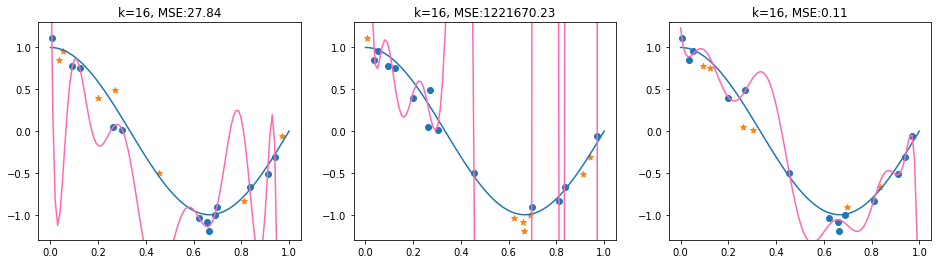

In [203]:
p=1
poly = PolynomialFeatures(16)
fig = plt.figure(figsize=(16, 4))
mse_array = []
for train, test in kf.split(D):
    plt.subplot(1, 3 , p)
    D_train, y_train = D[train], y[train]
    D_test, y_test = D[test], y[test]
    X_train = poly.fit_transform(D_train.reshape(-1, 1)) #design matrix for polynomal of degree k
    X_test = poly.fit_transform(D_test.reshape(-1, 1))
    β = np.linalg.solve(X_train.T@X_train, X_train.T@y_train)
    plt.scatter(D_train,y_train, marker='o')
    plt.scatter(D_test,y_test, marker='*')
    plt.plot(x,f_true(x))
    plt.plot(x,poly.fit_transform(x.reshape(-1, 1))@β, color='hotpink')
    plt.ylim(-1.3,1.3)
    plt.title('k=16, MSE:'+str(np.round(mse(X_test@β,y_test),2)))
    mse_array.append(np.round(mse(X_test@β,y_test),2))
    p+=1

The 3-fold CV-MSE is then given as the mean of the MSE values:

In [205]:
np.mean(mse_array)

407232.72666666674